# scipyによるダウンサンプリング

高いサンプリング周波数で計測された信号は、高い周波数の信号を含んでおり、情報量が豊富です。しかし一方で、データ量が大きくなるため、それ以降の計算処理に時間がかかってしまいます。計算によっては、信号の長さの2乗や3乗に比例する計算量になるものもあるため、計算結果に影響のない範囲でなるべく信号の長さを短くしたいところです。

そこで用いられるのがダウンサンプリングです。ダウンサンプリングは、LPF(Low Pass Filter)と間引きによって構成されています。LPFは任意の低い周波数の信号だけを通すフィルタのことです。間引きは、名前の通り、例えば1個おきにデータを捨てる等の操作のことです。

ここで、あまり詳しくない人は、「なぜLPFなどというものが必要なのか」と疑問に思うかもしれません。ここでは、その理屈を説明します。

### サンプリング定理とエリアジング（折返し）
ある信号の特徴を失わないように計測するには、サンプリング周波数(fs)が重要です。サンプリング定理に基づき、計測したい信号に含まれる最高周波数の2倍以上の周波数でサンプリングします。信号の性質が明らかでない場合は、サンプリングの前に、カットオフ周波数がfs/2以下のアナログローパスフィルタ(LPF)に通します。LPFがない場合、エリアジング誤差が生じることがあり、場合によっては全く使い物にならない信号となってしまいます。

### 間引きだけをした場合
では実際に、LPFを使わずに間引きだけした場合に、どのようにダメになるのか実際に試してみます。
#### やること
2種類の周波数の正弦波を合成して、間引き前と間引き後の波形とスペクトルを観察してみます。

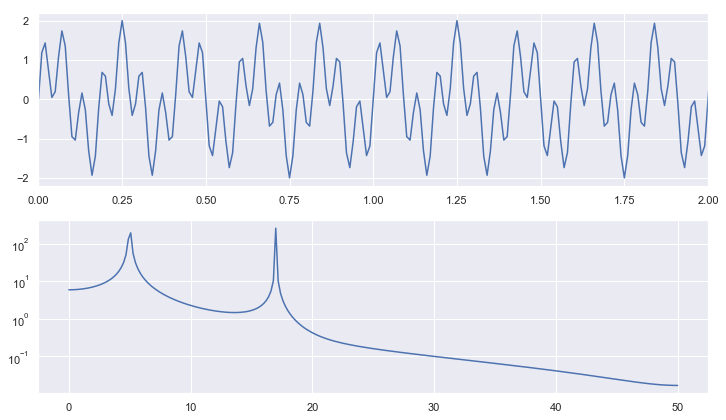

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

fs = 100  # 間引き前のサンプリング周波数
T = 10  # 信号の長さ[s]
f = [5, 17]  # 信号の周波数

# 信号の生成
t = np.linspace(0,T,T*fs+1)  # 時間軸（サンプリングのタイミング）
y = 0
for k in f:
    y = y + np.sin(2*np.pi*k*t)

# フーリエ変換（スペクトルを求める）
nfft = 512  # FFT点数（スペクトルの詳しさ）
x = np.linspace(0, fs/2, int(nfft/2+1))
Y = np.abs(np.fft.rfft(y, nfft))

# プロット    
sb.set()
ax, fig = plt.subplots(figsize=(12,7))
plt.subplot(2,1,1)  # 1つ目の図
plt.plot(t,y)  # 時間波形のプロット
plt.xlim(0,2)  # 0-2秒に制限
plt.subplot(2,1,2)  # 2つ目の図
plt.plot(x,Y)  # スペクトルのプロット
plt.yscale('log')  # 縦軸対数表示
plt.show()

fs=100Hzとして2つの正弦波を合成した信号を作り、その時間波形とスペクトルを表示しました。見やすくするため、時間波形は一部のみを表示しています。表せる信号の周波数はfs/2までですので、上限は50Hzになっています。スペクトルを見ると、5Hzと17Hzを表すピークがきれいに出ていることがわかります。

#### 間引いてみる
では、このfs=100Hzの信号を5個おきに間引いて、fs=20Hzの信号にしてみます。単純に、1個取ってきては、次の4個を捨てる、ということを繰り返します。この操作でデータ量は1/5になります。どんな事が起きるでしょうか？

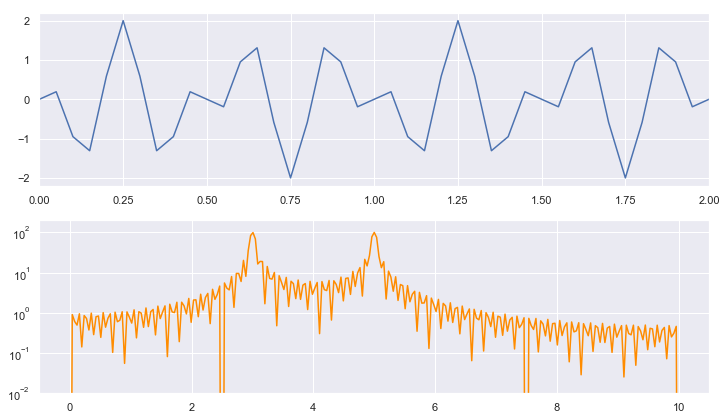

In [176]:
# 間引き（間引き後の各変数は _ をつけて表すことにします）
y_ = y[::5]  # 間引き
fs_ = fs/5  # 間引き後のサンプリング周波数
t_ = np.linspace(0,T,int(T*fs_)+1)  # 時間軸（サンプリングのタイミング）

# フーリエ変換（スペクトルを求める）
x_ = np.linspace(0,fs_/2,int(nfft/2+1))
Y_ = np.abs(np.fft.rfft(y_, nfft))

# プロット    
sb.set()
ax, fig = plt.subplots(figsize=(12,7))
plt.subplot(2,1,1)  # 1つ目の図
plt.plot(t_,y_)  # 時間波形のプロット
plt.xlim(0,2)  # 0-2秒に制限
plt.subplot(2,1,2)  # 2つ目の図
plt.plot(x_,Y_,color='darkorange')  # スペクトルのプロット
plt.yscale('log')  # 縦軸対数表示
plt.ylim(1e-2,2e2)  # 制限
plt.show()

スペクトルがギザギザしていたり、鋭さがなかったりは、今は気にしないでください。そう、今気にするところはもっと別のところです。

5Hzはもともと含まれている成分なので問題ないですが、なぜか3Hzにピークがあります。これは何でしょうか。実はこの3Hzの成分は、もともと17Hzの成分だったものが形を変えたものです。


コラム：エリアジングの語源



#### 詳しく波形を見てみる
なぜこんなことが起こるのかを調べます。とりあえず、17Hzの信号だけを再現して間引いてみます。

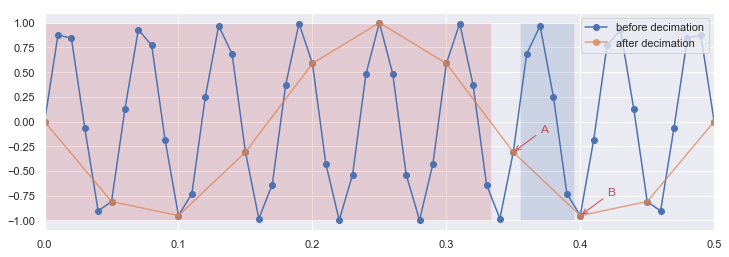

In [177]:
# 信号の生成
yy = np.sin(2*np.pi*17*t)
yy_ = yy[::5]

# プロット    
sb.set()
ax, fig = plt.subplots(figsize=(12,4))
plt.plot(t,yy, '-o')  # 時間波形のプロット
plt.plot(t_,yy_, '-o', alpha=0.7)
plt.xlim(0,0.5)  # 0-0.5秒に制限
plt.legend(['before decimation','after decimation'], loc=1)
plt.fill([0.355, 0.355, 0.395, 0.395],[-1,1,1,-1],alpha=0.2)
plt.fill([0, 0, 0.333, 0.333],[-1,1,1,-1],'r',alpha=0.2)
#plt.fill([0.145, 0.145, 0.155, 0.155],[-1,1,1,-1],'r',alpha=0.2)
plt.annotate('A', xy=(t_[7],yy_[7]), xytext=(t_[7]+0.02,yy_[7]+0.2), color='r', arrowprops=dict(arrowstyle='->',color='r'))
plt.annotate('B', xy=(t_[8],yy_[8]), xytext=(t_[8]+0.02,yy_[8]+0.2), color='r', arrowprops=dict(arrowstyle='->',color='r'))
plt.show()

青いグラフが間引き前、オレンジのグラフが間引き後です。0.5秒までのグラフを示しています。

まず図の右側を見てください。単純な間引き操作は、例えば'A'の点を取ってきて、青い領域に入っている次の4つの点を捨ててから、次の'B'の点を取ってくる、というものです。この操作を信号全体に渡って行います。

次に図の左側を見てください。赤い四角は間引き後のオレンジの正弦波のちょうど1周期分です。1周期の時間Tはグラフより約0.333秒ですので、この正弦波の周波数は1/T=3Hzであることが確認できます。ということでアラ不思議、間引いたら17Hzの信号が3Hzの信号になってしまいました。

このように、間引きによって生じる、間引き前と後の誤差（上の例では誤差というレベルではありませんが・・・）を折り返し誤差と呼びます。

#### 何が折り返し？
和名がなぜ「折返し」という名前になっているのでしょうか。

fs=100Hzの元の信号（青）には17Hzの成分が含まれていました。この信号を間引いてfs=20Hzとしました。このとき、間引き後の信号（橙）が表すことができる周波数の上限はfs/2=10Hzになります。すると、17Hzの信号は行き場がありません。かといって、勝手に消えたりしません。どこに行くかというと、上限の10Hzのところで折り返され、3Hzの信号として現れるのです。

この様子をプロットしてみます。

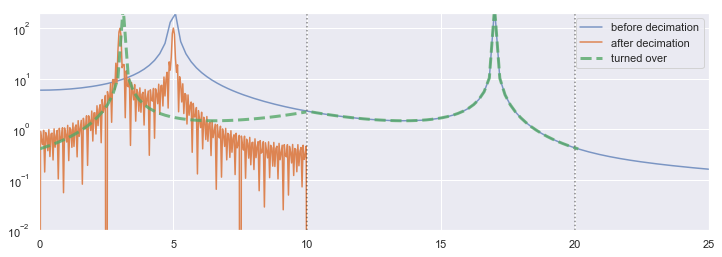

In [174]:
# プロット    
sb.set()
ax, fig = plt.subplots(figsize=(12,4))
plt.plot(x,Y, alpha=0.7)  # 間引き前のスペクトルのプロット
plt.plot(x_,Y_)  # 間引き後のスペクトルのプロット
plt.plot(x[52:104],Y[52:104], 'g', alpha=0.8, linewidth=3, linestyle='dashed')  # 元のスペクトル
plt.plot(x[0:52],Y[103:51:-1], 'g', alpha=0.8, linewidth=3, linestyle='dashed') # 折り返されたスペクトル
plt.plot([10,10],[1e-5,1e3], 'k' ,alpha=0.5, linestyle='dotted')
plt.plot([20,20],[1e-5,1e3], 'k' ,alpha=0.5, linestyle='dotted')
plt.yscale('log')  # 縦軸対数表示
plt.legend(['before decimation','after decimation','turned over'], loc=1)
plt.xlim(0,25)
plt.ylim(1e-2,2e2)  # 制限
plt.show()

青とオレンジのグラフはそれぞれ、すでに示した間引き前と間引き後のスペクトルです。緑色の点線は、10～20Hzのスペクトルが10Hzを境に左右ひっくり返って10～0Hzに折り返される様子を表しています。このひっくり返ったスペクトル(17Hzにピーク)は、間引き後のオレンジのスペクトル(3Hzにピーク)に重なっています。このように、fs/2(10Hz)より高い周波数の信号は、間引きによって周波数領域上で折り返されるのです。これが折り返し誤差と呼ばれる所以です。

#### ちなみに20Hzより高い信号はどうなるの？
例えば、22Hzの信号は2Hzになります。これはみなさん自身の手で確かめてください。上のpythonコードを少し変えれば確かめられます。

#### どうやって折り返し誤差をなくすの？
以上の話で、間引くことで結局10Hz以上の信号は表現できなくなってしまう、ということは、もうおわかりかと思います。折返し誤差の正体は17Hzの信号ということでしたので、折返し誤差をなくすには、間引く前にこの17Hzの信号を除去してしまえばよいのです。そこでLPFの出番です。

### ダウンサンプリングのためのLPF
これまでに、ダウンサンプリングのためには、折返し誤差を回避するためLPFが必須だということがわかりました。本来ならここでどういったLPFがふさわしいのか、という議論をするところですが、LPF設計は非常に奥が深く一筋縄ではいきません。しかし嬉しいことに、pythonの科学計算モジュールであるscipyには、幸いこのLPFと間引きを両方やってくれる便利な関数があります。それが`scipy.signal.decimate()`です。

## まとめ
以上より、正規化した場合の共分散の最大値が0.15であって、1に比べてだいぶ小さいため、かなりの確かさで識別できそうだということがわかりました。次は実際に録音したゲーム音声で、識別可能性を確認します。